Deep Learning
=============

Assignment 3
------------

Previously in `2_fullyconnected.ipynb`, you trained a logistic regression and a neural network model.

The goal of this assignment is to explore regularization techniques.

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle
import matplotlib.pyplot as plt

# Config the matplotlib backend as plotting inline in IPython
%matplotlib inline

First reload the data we generated in `1_notmnist.ipynb`.

In [2]:
pickle_file = 'notMNIST.pickle'

with open(pickle_file, 'rb') as f:
    save = pickle.load(f)
    train_dataset = save['train_dataset']
    train_labels = save['train_labels']
    valid_dataset = save['valid_dataset']
    valid_labels = save['valid_labels']
    test_dataset = save['test_dataset']
    test_labels = save['test_labels']
    del save    # hint to help gc free up memory
    print('Training set', train_dataset.shape, train_labels.shape)
    print('Validation set', valid_dataset.shape, valid_labels.shape)
    print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 28, 28) (200000,)
Validation set (10000, 28, 28) (10000,)
Test set (10000, 28, 28) (10000,)


Reformat into a shape that's more adapted to the models we're going to train:
- data as a flat matrix,
- labels as float 1-hot encodings.

In [3]:
image_size = 28
num_labels = 10

def reformat(dataset, labels):
    dataset = dataset.reshape((-1, image_size * image_size)).astype(np.float32)
    # Map 1 to [0.0, 1.0, 0.0 ...], 2 to [0.0, 0.0, 1.0 ...]
    labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
    return dataset, labels

train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)

print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 784) (200000, 10)
Validation set (10000, 784) (10000, 10)
Test set (10000, 784) (10000, 10)


Introduce helper function for calculating accuracy.

In [4]:
def accuracy(predictions, labels):
    return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
                    / predictions.shape[0])

Progress bar to visualize accuracy.

In [5]:
from ipywidgets import IntProgress
from IPython.display import display

def progress(max):
    p = IntProgress(max = max)
    p.description = 'Running'
    display(p)
    return p

---
Problem 1
---------

Introduce and tune L2 regularization for both logistic and neural network models. Remember that L2 amounts to adding a penalty on the norm of the weights to the loss. In TensorFlow, you can compute the L2 loss for a tensor `t` using `nn.l2_loss(t)`. The right amount of regularization should improve your validation / test accuracy.

---

# We will start with logistic model

In [6]:
l2_loss = 0.01
batch_size = 128
graph = tf.Graph()

with graph.as_default():
    # Input data. For the training data, we use a placeholder that will be fed
    # at run time with a training minibatch.
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    tf_l2_loss = tf.placeholder(tf.float32)

    # Variables.
    weights = tf.Variable(
        tf.truncated_normal([image_size * image_size, num_labels]))
    biases = tf.Variable(tf.zeros([num_labels]))

    # Training computation.
    logits = tf.matmul(tf_train_dataset, weights) + biases
    loss = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits)) + tf_l2_loss * tf.nn.l2_loss(weights)

    # Optimizer.
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)

    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    valid_prediction = tf.nn.softmax(tf.matmul(tf_valid_dataset, weights) + biases)
    test_prediction = tf.nn.softmax(tf.matmul(tf_test_dataset, weights) + biases)

Let`s run it!

Trainitng model with L2 regularization: 0.000100
Initialized


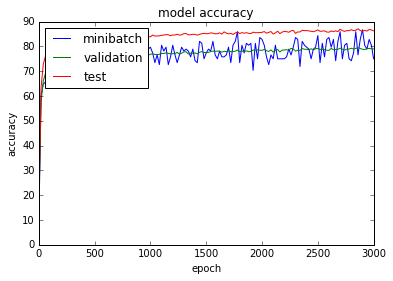

Test accuracy: 86.3%
Trainitng model with L2 regularization: 0.001000
Initialized


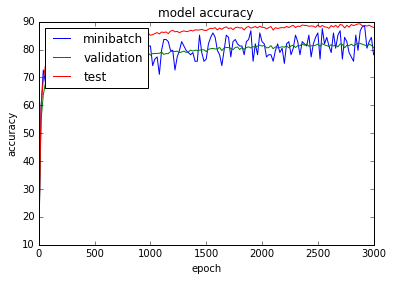

Test accuracy: 87.9%
Trainitng model with L2 regularization: 0.010000
Initialized


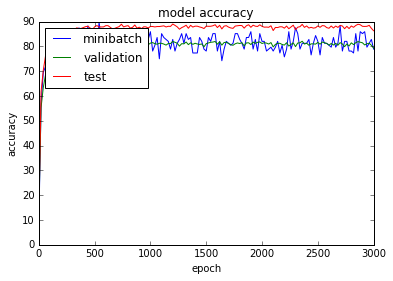

Test accuracy: 86.3%
Trainitng model with L2 regularization: 0.030000
Initialized


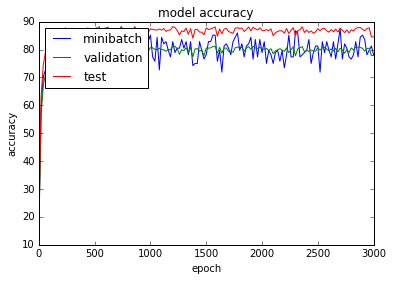

Test accuracy: 84.5%
Trainitng model with L2 regularization: 0.100000
Initialized


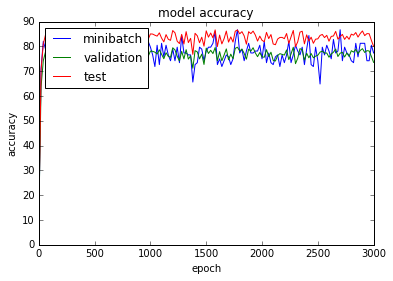

Test accuracy: 80.0%
Trainitng model with L2 regularization: 0.300000
Initialized


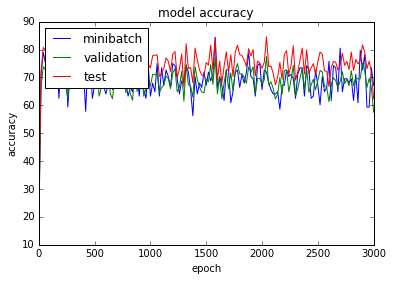

Test accuracy: 62.4%


In [7]:
num_steps = 3001
period_stat = 20

def plot(history):
    # summarize history for accuracy
    plt.plot(history['steps'], history['minibatch'])
    plt.plot(history['steps'], history['validation'])
    plt.plot(history['steps'], history['test'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['minibatch', 'validation', 'test'], loc='upper left')
    plt.show()

def train_logistic(l2_loss):
    print("Trainitng model with L2 regularization: %f" % l2_loss)
    history = {
        'minibatch' : [],
        'validation' : [],
        'test' : [],
        'steps' : []
    }

    with tf.Session(graph=graph) as session:
        tf.global_variables_initializer().run()
        print("Initialized")
        for step in range(num_steps):

            # Pick an offset within the training data, which has been randomized.
            offset = (step * batch_size) % (train_labels.shape[0] - batch_size)

            # Generate a minibatch.
            batch_data = train_dataset[offset:(offset + batch_size), :]
            batch_labels = train_labels[offset:(offset + batch_size), :]

            # Prepare a dictionary telling the session where to feed the minibatch.
            feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, tf_l2_loss: l2_loss}
            _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)

            if (step % period_stat == 0):
                history["steps"].append(step)
                history["validation"].append(accuracy(valid_prediction.eval(), valid_labels))
                history["minibatch"].append(accuracy(predictions, batch_labels))
                history["test"].append(accuracy(test_prediction.eval(), test_labels))

        plot(history)
        print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

try_loss = [0.0001, 0.001, 0.01, 0.03, 0.1, 0.3]
for l2_loss in try_loss:
    train_logistic(l2_loss)

## Let's create a neural network with one hidden layer, RELU nonlinearity and optional l2 regularization and dropout.

Create tensorflow graph.

In [8]:
hidden_nodes = 1024
batch_size = 128

nn_with_hidden_layer = tf.Graph()

with nn_with_hidden_layer.as_default():
    
    # Input data
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    l2 = tf.placeholder(tf.float32)
    p_dropout = tf.placeholder(tf.float32)
    
    # Variables
    
    # 1st layer
    w1 = tf.Variable(
        tf.truncated_normal([image_size * image_size, hidden_nodes]))
    b1 = tf.Variable(tf.zeros([hidden_nodes]))
    
    # hidden layer
    w2 = tf.Variable(
        tf.truncated_normal([hidden_nodes, num_labels]))
    b2 = tf.Variable(tf.zeros([num_labels]))
    
    def model(X):
        # Add layer name scopes for better graph visualization
        with tf.name_scope("input_layer"):
            h = tf.nn.relu(tf.matmul(X, w1) + b1)
        with tf.name_scope("hidden_layer"):
            h = tf.nn.dropout(h, p_dropout)
            h2 = tf.matmul(h, w2) + b2
            return(h2)
    
    logits = model(tf_train_dataset)
    
    # Training computation
    loss = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits)
    ) + l2 * tf.nn.l2_loss(w1) + l2 * tf.nn.l2_loss(w2)
    
    # Optimizer.
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
    
    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    valid_prediction = tf.nn.softmax(model(tf_valid_dataset))
    test_prediction = tf.nn.softmax(model(tf_test_dataset))

Create training function.

In [9]:
num_steps = 3001
period_stat = 500

def train_neural_n(l2_reg, dropout, stats = False, restrict_num_batches = False):
    
    print("Starting training with parameters: l2_reg: {0}, dropout: {1}".format(l2_reg, dropout))
    p = progress(num_steps)
    
    # Can vary the amount of training batches.
    max_offset = train_labels.shape[0]
    if (restrict_num_batches != False):
        max_offset = restrict_num_batches * batch_size
    
    with tf.Session(graph=nn_with_hidden_layer) as session:
        tf.global_variables_initializer().run()
        for step in range(num_steps):

            # Pick an offset within the training data, which has been randomized.
            offset = (step * batch_size) % (max_offset - batch_size)

            # Generae minibatch.
            batch_data = train_dataset[offset:(offset + batch_size), :]
            batch_labels = train_labels[offset:(offset + batch_size), :]

            # Dictionaries to pass to session.
            train_d = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, l2: l2_reg, p_dropout: dropout}
            stat_d = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, l2: l2_reg, p_dropout: 1.0}
            
            _ = session.run(optimizer, feed_dict=train_d)
            
            p.value = step
            
            if (step % period_stat == 0) & (stats == True):
                l, train_pred, valid_pred = session.run([loss, train_prediction, valid_prediction], feed_dict=stat_d)
                print(
                    "Step {0}: \n loss: {1} \n minibatch acc: {2}% \n validation acc: {3}% \n".format(
                        step,
                        l,
                        accuracy(train_pred, batch_labels),
                        accuracy(valid_pred, valid_labels)
                    )
                )
        
        test_pred = session.run(test_prediction, feed_dict=stat_d)
        valid_pred = session.run(valid_prediction, feed_dict=stat_d) 
        
        print("Accuracy on validation dataset: %.1f%% \n" % accuracy(valid_pred, valid_labels))
        return([accuracy(valid_pred, valid_labels), accuracy(test_pred, test_labels)])

We explore different amounts of l2 regularization and select model with the best validation dataset accuracy.  

In [11]:
try_l2 = [0.0001, 0.0003, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3]
valid_acc = []
test_acc = []
for l2_reg in try_l2:
    v, t = train_neural_n(l2_reg, dropout = 1.0)
    valid_acc.append(v)
    test_acc.append(t)

best_l2 = np.array(valid_acc).argmax()
print("Best level of l2 regularization: {0}".format(try_l2[best_l2]))
print("Accuracy on test dataset: {0}%".format(test_acc[best_l2]))

Starting training with parameters: l2_reg: 0.0001, dropout: 1.0
Accuracy on validation dataset: 82.8% 

Starting training with parameters: l2_reg: 0.0003, dropout: 1.0
Accuracy on validation dataset: 83.5% 

Starting training with parameters: l2_reg: 0.001, dropout: 1.0
Accuracy on validation dataset: 86.7% 

Starting training with parameters: l2_reg: 0.003, dropout: 1.0
Accuracy on validation dataset: 86.0% 

Starting training with parameters: l2_reg: 0.01, dropout: 1.0
Accuracy on validation dataset: 83.5% 

Starting training with parameters: l2_reg: 0.03, dropout: 1.0
Accuracy on validation dataset: 81.1% 

Starting training with parameters: l2_reg: 0.1, dropout: 1.0
Accuracy on validation dataset: 75.8% 

Starting training with parameters: l2_reg: 0.3, dropout: 1.0
Accuracy on validation dataset: 56.5% 

Best level of l2 regularization: 0.001
Accuracy on test dataset: 93.11%


---
Problem 2
---------
Let's demonstrate an extreme case of overfitting. Restrict your training data to just a few batches. What happens?

---

In [12]:
v, t = train_neural_n(l2_reg = 0.0, dropout = 1.0, restrict_num_batches = 5)
print("Accuracy on validation dataset: {0}%".format(v))
print("Accuracy on test dataset: {0}%".format(t))

Starting training with parameters: l2_reg: 0.0, dropout: 1.0
Accuracy on validation dataset: 76.8% 

Accuracy on validation dataset: 76.78%
Accuracy on test dataset: 83.81%


---
Problem 3
---------
Introduce Dropout on the hidden layer of the neural network. Remember: Dropout should only be introduced during training, not evaluation, otherwise your evaluation results would be stochastic as well. TensorFlow provides `nn.dropout()` for that, but you have to make sure it's only inserted during training.

What happens to our extreme overfitting case?

---

In [13]:
try_dropout = [1.0, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4]
valid_acc = []
test_acc = []
for dropout in try_dropout:
    v, t = train_neural_n(0.0, dropout)
    valid_acc.append(v)
    test_acc.append(t)

best_dropout = np.array(valid_acc).argmax()
print("Best level of dropout: {0}".format(try_dropout[best_dropout]))
print("Accuracy on test dataset: {0}%".format(test_acc[best_dropout]))

Starting training with parameters: l2_reg: 0.0, dropout: 1.0
Accuracy on validation dataset: 81.9% 

Starting training with parameters: l2_reg: 0.0, dropout: 0.9
Accuracy on validation dataset: 81.6% 

Starting training with parameters: l2_reg: 0.0, dropout: 0.8
Accuracy on validation dataset: 81.8% 

Starting training with parameters: l2_reg: 0.0, dropout: 0.7
Accuracy on validation dataset: 81.3% 

Starting training with parameters: l2_reg: 0.0, dropout: 0.6
Accuracy on validation dataset: 80.5% 

Starting training with parameters: l2_reg: 0.0, dropout: 0.5
Accuracy on validation dataset: 80.0% 

Starting training with parameters: l2_reg: 0.0, dropout: 0.4
Accuracy on validation dataset: 79.3% 

Best level of dropout: 1.0
Accuracy on test dataset: 88.57%


In [14]:
print(test_acc)

[88.57, 88.7, 88.5, 88.8, 87.54, 86.93, 86.02]


In [15]:
v, t = train_neural_n(l2_reg = 0.0, dropout = 0.8, restrict_num_batches = 5)
print("Accuracy on validation dataset: {0}%".format(v))
print("Accuracy on test dataset: {0}%".format(t))

Starting training with parameters: l2_reg: 0.0, dropout: 0.8
Accuracy on validation dataset: 78.5% 

Accuracy on validation dataset: 78.47%
Accuracy on test dataset: 85.43%


---
Problem 4
---------

Try to get the best performance you can using a multi-layer model! The best reported test accuracy using a deep network is [97.1%](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html?showComment=1391023266211#c8758720086795711595).

One avenue you can explore is to add multiple layers.

Another one is to use learning rate decay:

        global_step = tf.Variable(0)    # count the number of steps taken.
        learning_rate = tf.train.exponential_decay(0.5, global_step, ...)
        optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
 
 ---
